# Final results for the working memory dataset

In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)

from statsmodels.stats.anova import AnovaRM # perform F test

In [2]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'

<font color = 'grey'>Defining functions specific to this dataset

In [3]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    THIS ONLY WORKS FOR WM dataset
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation
        Example agg_kw: {'load': 'first',
                         'phase': 'first',
                         'recall': 'first',
                         'X': np.mean,
                         'Y': np.mean}
    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    
    return g_df

# add text labels to points
def annotate(dataframe, text_size = 'small', text_weight = 'regular', labels = "load"):
    """
    annotate data points in the scatterplot
    Args:
    dataframe (pd.DataFrame)
    text_size (str) 
    text_weight (str)
    labels (str) - column of the dataframe that is to be used as label
    """
    texts = []
    for i in range(dataframe.shape[0]):   
        text = plt.text(
                        dataframe.X[i]+0.001, 
                        dataframe.Y[i], 
                        s = dataframe[labels][i],
                        horizontalalignment='left', 
                        size=text_size, 
                        weight=text_weight
                        )
        texts.append(text)

    adjust_text(texts) # make sure you have installed adjust_text

# plotting:
def make_plot(dataframe, hue = "phase", style = "recall", label = "load", height = 4, aspect = 1):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 100)
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = df_preped['X'], 
                        y = df_preped['Y'], 
                        yerr = df_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')

    # get labels for each data point
    annotate(df_preped, text_size = 'small', text_weight = 'regular', labels = label)
    return

## 1. Plots and test results
investigating linearity

### 1.1 Over the whole cerebellum and cortex

<font color = 'grey'>Prepare the dataframe for the scatterplot

In [4]:
# load the dataframe for the whole 
df_path = os.path.join(base_dir, "WMFS", "sc_df_whole_ses-02.tsv")
df = pd.read_csv(df_path, sep="\t")
# display(df)

# cleaning up (changing ints to strings)
df['phase']   = df['phase'].map({1: 'retriev', 0: 'encode'}) 
df['recall']  = df['recall'].map({1: 'fw', 0: 'bw'}) 
df['load']    = df['load'].map({2:'load2', 4:'load4', 6:'load6'})

# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'load': 'first', 'phase': 'first', 'recall': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df, groupby = "cond_name", agg_kw=agg_kw)
# df_preped
    

<font color = 'grey'> Do the scatterplot:<br>
The task has 3 factors: phase (encoding, retrieval), recall direction (forward, backward), and load (2, 4, 6).<br>
* Phase will be used to determine the color of each data point
* Recall direction determines the shape of the marker
* Load will be displayed as label next to the data point

For more help on Facetgrid see https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

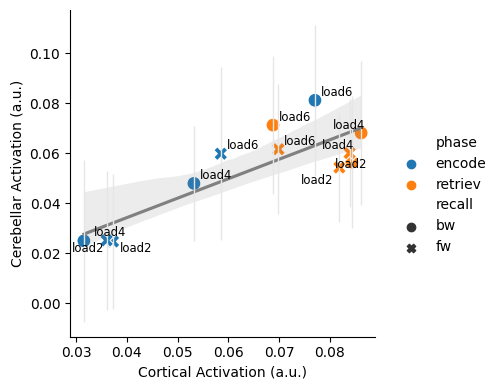

In [5]:
make_plot(df_preped, hue = "phase", style = "recall", label = "load", height = 4, aspect = 1)

Figure 1. Scatterplot showing average cerebellar activation in each condition vs the corresponding average activation in the cortex. The linear fit is shown in grey. Error bars represent the standard deviation of the residuals of the linear regression fit. 

<font color = 'grey'> Do F-test (repeated measures ANOVA)

In [6]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  5.4452 11.0000 165.0000 0.0000



### 1.2 Over region of interests
#### 1.2.1 verbal working memory contrast

<font color = 'grey'>Prepare the dataframe for the scatterplot

In [10]:
# load the dataframe for the whole 
df_path = os.path.join(base_dir, "WMFS", "sc_df_VWM_ses-02.tsv")
df = pd.read_csv(df_path, sep="\t")

# cleaning up (changing ints to strings)
df['phase']   = df['phase'].map({1: 'retriev', 0: 'encode'}) 
df['recall']  = df['recall'].map({1: 'fw', 0: 'bw'}) 
df['load']    = df['load'].map({2:'load2', 4:'load4', 6:'load6'})

# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'load': 'first', 'phase': 'first', 'recall': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df, groupby = "cond_name", agg_kw=agg_kw)

<font color = 'grey'> Do the scatterplot:<br>

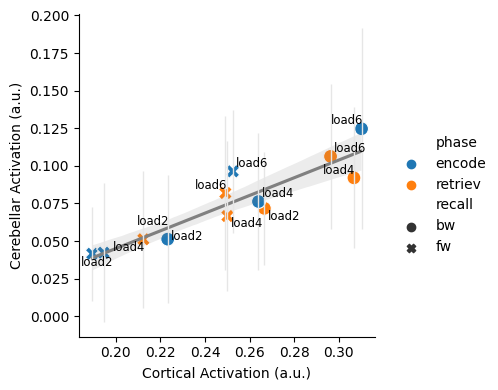

In [8]:
make_plot(df_preped, hue = "phase", style = "recall", label = "load", height = 4, aspect = 1)

Figure 2.

<font color = 'grey'> Do F-test (repeated measures ANOVA)

In [9]:
print(AnovaRM(data=df, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  2.3959 11.0000 165.0000 0.0088



### 1.3 Using connectivity models